In [1]:
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader

import helper
import data_loading
import time

In [2]:
train_data, test_data, emotion_map = data_loading.get_data()
emotion_decode = {}

for emot, val in emotion_map.items():
    emotion_decode[val] = emot
print(emotion_map)
print(emotion_decode)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
28709 7178
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.module = nn.Sequential(
            nn.Conv2d(1, 16, (3, 3)),
            nn.ReLU(),

            nn.Conv2d(16, 16, (3, 3)),
            nn.ReLU(),
            
            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, (3, 3)),
            nn.ReLU(),
            
            nn.Conv2d(32, 32, (3, 3)),
            nn.ReLU(),
            
            nn.MaxPool2d(2),
            
            nn.Flatten(),
            
            nn.Linear(32 * 9 * 9, 512),
            nn.Tanh(),
            nn.Linear(512, 64),
            nn.Tanh(),
            nn.Linear(64, 7),
            nn.Softmax(dim=1)           
        )
    
    def forward(self, x):
        return self.module(x)
    
device = "cuda"
model = Model().to(device)

total_params = 0
for p in model.parameters():
    total_params += p.numel()
print(f"total_params : {total_params:,}")

total_params : 1,377,271


In [4]:
results = []

In [5]:
batch = 1024
epoch = 150
lr = 1e-4

results = list(results)

train_data_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=batch, shuffle=True)

loss_fn = nn.CrossEntropyLoss(helper.get_weight(train_data, device))
optimizer = torch.optim.Adam(model.parameters(), lr)

for _ in range(epoch):
    s = time.time()
    results.append(helper.fit(model, 
                              train_data_loader,
                              test_data_loader,
                              loss_fn,
                              optimizer,
                              device 
                            )
                    )
    e = time.time()
    e = round(e - s, 3)
    print(_, e, results[-1], sep = "\t")

0	6.191	[1.945546298191465, 17.701765996725765, 1.94400355219841, 12.148230704931736]
1	5.352	[1.9393173086232152, 13.786617437040649, 1.9239698499441147, 17.957648370019506]
2	5.229	[1.9286537663689975, 18.196384409070326, 1.9182336181402206, 20.590693786570075]
3	4.736	[1.9209865454969735, 20.00069664565119, 1.9180926084518433, 22.9869044302034]
4	4.544	[1.9155158791048774, 22.097600055731654, 1.909180372953415, 24.240735580941767]
5	4.532	[1.9027413047593216, 24.849350377930264, 1.8899587392807007, 27.31958762886598]
6	4.753	[1.8899463990638996, 26.8417569403323, 1.8707290291786194, 31.220395653385346]
7	5.297	[1.8778633372537021, 29.29046640426347, 1.8694964051246643, 30.74672610755085]
8	6.082	[1.8688947373423084, 29.614406632066597, 1.8588513880968094, 29.297854555586518]
9	6.077	[1.86193271340995, 29.771151903584244, 1.8682564347982407, 30.94176650877682]
10	6.008	[1.8546085645412576, 29.31833223031105, 1.854621559381485, 32.59960991919755]
11	5.799	[1.8489759667166348, 31.15399

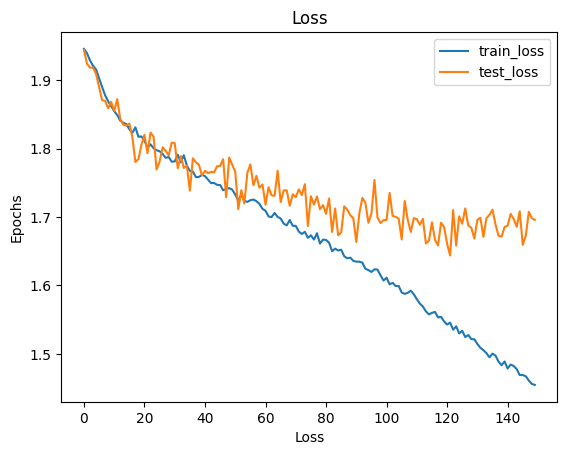

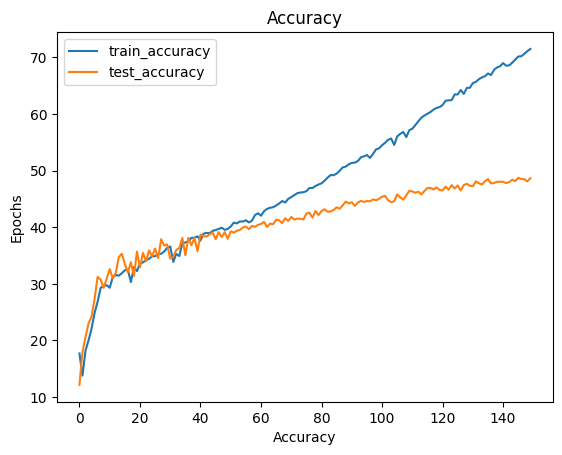

In [6]:
results = np.array(results)
helper.plot_result(results)

In [7]:
confusion_matrix = helper.make_confusion_matrix(model, test_data_loader, 7, "cuda")
confusion_matrix = confusion_matrix/confusion_matrix.sum()

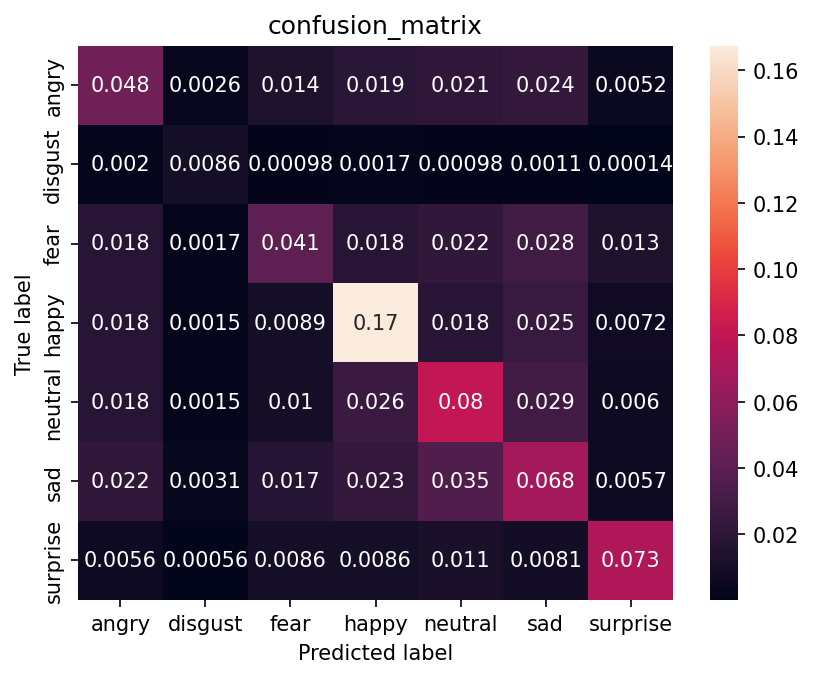

In [8]:
tick_label = [emotion_decode[i] for i in range(7)]
helper.plot_confusion_matrix(confusion_matrix, tick_label)

In [9]:
confusion_matrix

tensor([[4.8481e-02, 2.6470e-03, 1.3514e-02, 1.8947e-02, 2.1176e-02, 2.3544e-02,
         5.1546e-03],
        [1.9504e-03, 8.6375e-03, 9.7520e-04, 1.6718e-03, 9.7520e-04, 1.1145e-03,
         1.3931e-04],
        [1.8250e-02, 1.6718e-03, 4.0680e-02, 1.7972e-02, 2.2290e-02, 2.8420e-02,
         1.3374e-02],
        [1.8250e-02, 1.5325e-03, 8.9161e-03, 1.6746e-01, 1.8250e-02, 2.5495e-02,
         7.2444e-03],
        [1.8250e-02, 1.5325e-03, 1.0170e-02, 2.6191e-02, 8.0385e-02, 2.9256e-02,
         5.9905e-03],
        [2.2151e-02, 3.0649e-03, 1.6857e-02, 2.2848e-02, 3.5107e-02, 6.7986e-02,
         5.7119e-03],
        [5.5726e-03, 5.5726e-04, 8.6375e-03, 8.6375e-03, 1.1284e-02, 8.0802e-03,
         7.3001e-02]])